# The Price is Right

1. This notebook: Random Forest pricer and create a Ensemble pricer that allows contributions from all the pricers

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [7]:
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# rf_model.fit(vectors, prices)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [8]:
# Save the model to a file

# joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [7]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [8]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [9]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

C:\Users\Admin\Anaconda3\envs\llms\Lib\asyncio\events.py:84: DeprecationError: 2025-01-27: `modal.Cls.lookup` is deprecated and will be removed in a future release. It can be replaced with `modal.Cls.from_name`.

See https://modal.com/docs/guide/modal-1-0-migration for more information.
  self._context.run(self._callback, *self._args)


In [10]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [11]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $299.77 Truth: $374.41 Error: $74.64 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $200.04 Truth: $225.11 Error: $25.07 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $203.10 Truth: $61.68 Error: $141.42 SLE: 1.39 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $374.11 Truth: $599.99 Error: $225.88 SLE: 0.22 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $216.54 Truth: $16.99 Error: $199.55 SLE: 6.21 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $54.12 Truth: $31.99 Error: $22.13 SLE: 0.26 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $278.88 Truth: $101.79 Error: $177.09 SLE: 1.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $237.53 Truth: $289.00 Error: $51.47 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $303.42 Truth: $635.86 Error: $332.44 SLE: 0.54 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $176.04 Truth: $65.99 Error: $110.05 SLE

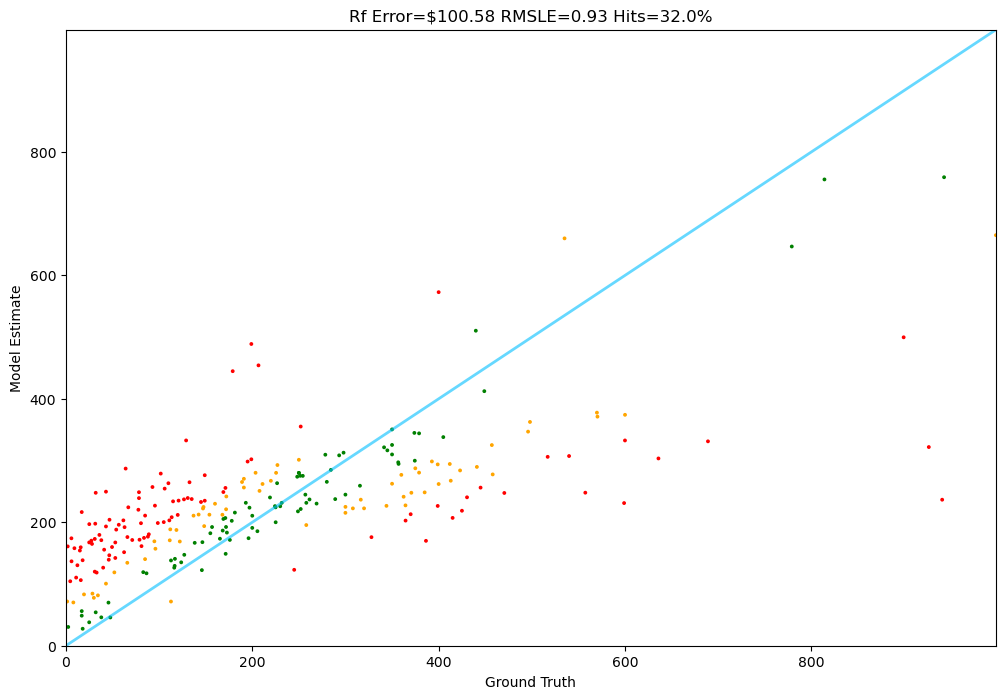

In [12]:
Tester.test(rf, test)

In [13]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [14]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

189.0
195.19
278.4613000000002


In [26]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [12:50<00:00,  3.08s/it]


In [27]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [28]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.44
Frontier: 0.21
RandomForest: -0.34
Min: 0.36
Max: 0.30
Intercept=24.20


In [29]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [19]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

C:\Users\Admin\Anaconda3\envs\llms\Lib\asyncio\events.py:84: DeprecationError: 2025-01-27: `modal.Cls.lookup` is deprecated and will be removed in a future release. It can be replaced with `modal.Cls.from_name`.

See https://modal.com/docs/guide/modal-1-0-migration for more information.
  self._context.run(self._callback, *self._args)


In [20]:
ensemble.price(product)

207.00477110001287

In [21]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

1: Guess: $404.29 Truth: $374.41 Error: $29.88 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $206.23 Truth: $225.11 Error: $18.88 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $50.58 Truth: $61.68 Error: $11.10 SLE: 0.04 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $384.33 Truth: $599.99 Error: $215.66 SLE: 0.20 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $35.08 Truth: $16.99 Error: $18.09 SLE: 0.48 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $37.94 Truth: $31.99 Error: $5.95 SLE: 0.03 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $111.79 Truth: $101.79 Error: $10.00 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $366.89 Truth: $289.00 Error: $77.89 SLE: 0.06 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $887.66 Truth: $635.86 Error: $251.80 SLE: 0.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $72.81 Truth: $65.99 Error: $6.82 SLE: 0.01 It

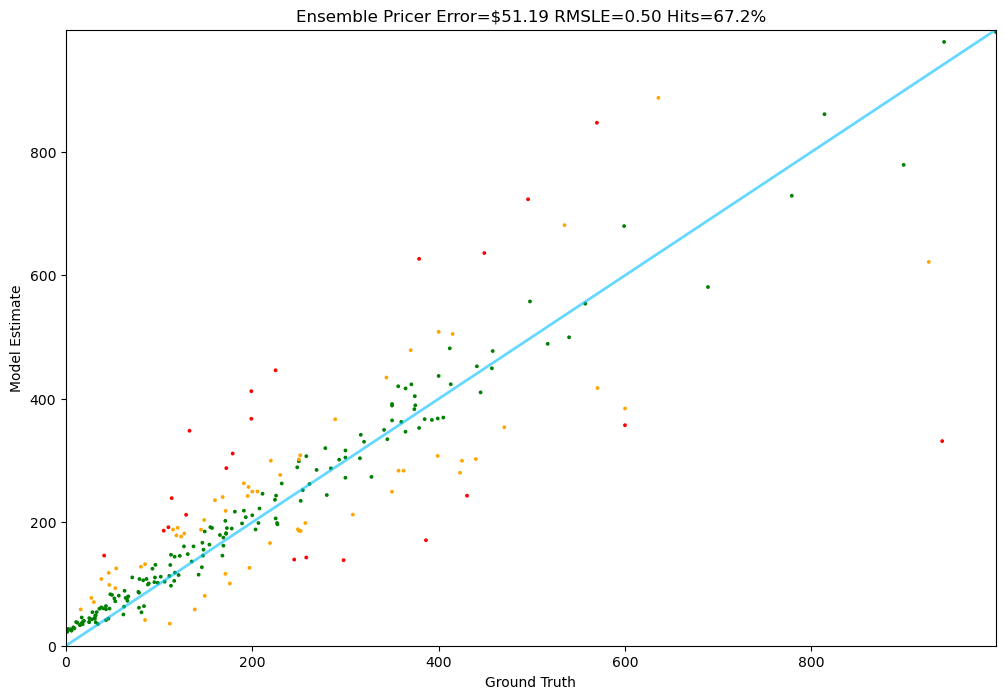

In [22]:
Tester.test(ensemble_pricer, test)